In [24]:
from load_model import load_model
import numpy as np
import torch

In [3]:
model = load_model("CSMAE-CECD", 0)
model

Architecture setup: 0x separate encoders + 12x shared encoders

HINT: Loaded checkpoint (<All keys matched successfully>)


CrossModalMaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(2, 768, kernel_size=(15, 15), stride=(15, 15))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
   

In [8]:
from src.bigearthnet_dataset.BEN_lmdb_utils import BENLMDBReader, read_ben_from_lmdb

reader = BENLMDBReader(
    lmdb_dir="csmae_data/BigEarthNetEncoded.lmdb",
    label_type="new",
    image_size=(2, 120, 120),
    bands=2,
)

In [28]:
test_patch = read_ben_from_lmdb(reader.env, "S1A_IW_GRDH_1SDV_20180521T044858_34WFS_78_3")
test_input = np.stack([test_patch.bandVH.data, test_patch.bandVV.data])
test_input_tensor = torch.tensor(test_input[np.newaxis], device="cuda:0")
test_input_tensor.shape

torch.Size([1, 2, 120, 120])

In [31]:
N = 1
L = 2

# sort noise for each sample
noise = torch.rand(N, L, device="cuda:0")  # noise in [0, 1]
ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
ids_restore = torch.argsort(ids_shuffle, dim=1)


x, mask, ids_restore = model.forward_encoder_s1(test_input_tensor, 0, ids_shuffle, ids_restore)
x.shape, mask, ids_restore

(torch.Size([1, 3, 768]),
 tensor([[0., 0.]], device='cuda:0'),
 tensor([[1, 0]], device='cuda:0'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_5941/2490757524.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


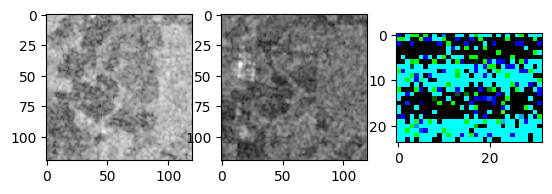

In [40]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, squeeze=True)
axs[0].imshow(test_input[0], cmap="gray")
axs[1].imshow(test_input[1], cmap="gray")
axs[2].imshow(x.cpu().detach().numpy().reshape((3, 24, 32)).transpose((1, 2, 0)))
fig.show()

In [45]:
# The forward function expects 10 channels S2 concatenated with 2 channels S1.
# We set all S2 channels to 0 as they do not influence the S1 output.
input_tensor_12chan = torch.zeros((1, 12, 120, 120), device="cuda:0")
input_tensor_12chan[0, 10:] = test_input_tensor[0]
output = model(input_tensor_12chan)
{k: output[k].shape for k in output}

{'s1': torch.Size([1, 768]), 's2': torch.Size([1, 768])}

In [69]:
test_input[1].max()

6.5208545

In [71]:
# source: https://discuss.pytorch.org/t/finding-model-size/130275
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 332.581MB


In [76]:
# source: https://discuss.pytorch.org/t/pytorch-model-size-in-mbs/149002
size_model = 0
for param in model.parameters():
    if param.data.is_floating_point():
        size_model += param.numel() * torch.finfo(param.data.dtype).bits
    else:
        size_model += param.numel() * torch.iinfo(param.data.dtype).bits
print(f"model size: {size_model} / bit | {size_model / 8e6:.2f} / MB")

model size: 2789892096 / bit | 348.74 / MB


In [79]:
from torchsummary import summary
summary(model, (12, 120, 120))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 8, 8]         346,368
          Identity-2              [-1, 64, 768]               0
        PatchEmbed-3              [-1, 64, 768]               0
            Conv2d-4            [-1, 768, 8, 8]       1,728,768
          Identity-5              [-1, 64, 768]               0
        PatchEmbed-6              [-1, 64, 768]               0
         LayerNorm-7              [-1, 65, 768]           1,536
            Linear-8             [-1, 65, 2304]       1,771,776
          Identity-9           [-1, 12, 65, 64]               0
         Identity-10           [-1, 12, 65, 64]               0
          Dropout-11           [-1, 12, 65, 65]               0
           Linear-12              [-1, 65, 768]         590,592
          Dropout-13              [-1, 65, 768]               0
        Attention-14              [-1, 